Required: pip install pandas numpy matplotlib seaborn scikit-learn aif360
------------------------------------------------------------
COMPAS Dataset Bias Audit: False Positive Rate Analysis
Loading COMPAS dataset...
Dataset shape after preprocessing: (5278, 57)


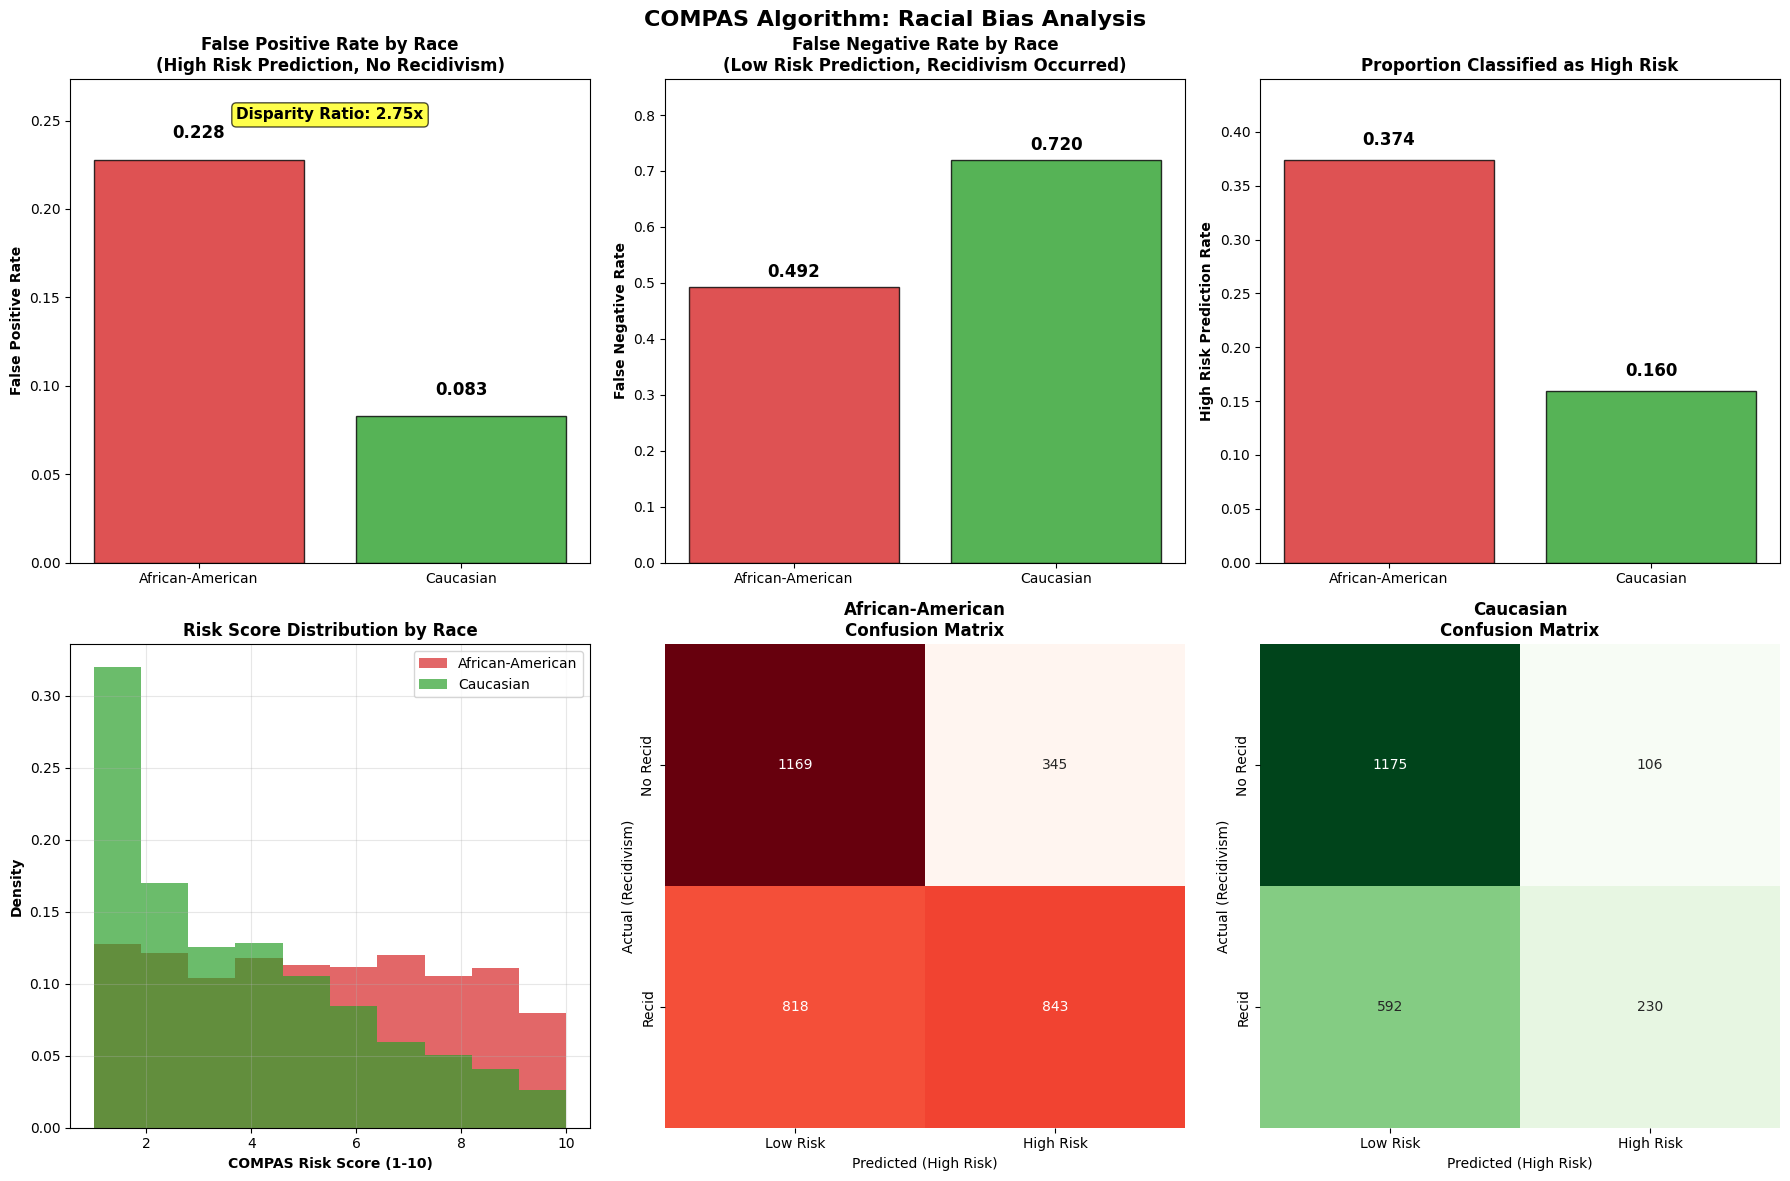


BIAS AUDIT REPORT
COMPAS RECIDIVISM ALGORITHM BIAS AUDIT REPORT

EXECUTIVE SUMMARY:
This audit analyzed 5278 defendants in the COMPAS dataset, revealing significant racial disparities in risk assessment predictions between African-American and Caucasian defendants.

KEY FINDINGS:
The analysis uncovered substantial bias in false positive rates. African-American defendants experience a 2.75x higher false positive rate (0.228) compared to Caucasian defendants (0.083). This means African-American defendants are 2.75 times more likely to be incorrectly classified as high-risk when they will not reoffend.

Conversely, Caucasian defendants show a higher false negative rate (0.720 vs 0.492), meaning they are more likely to be incorrectly classified as low-risk when they will reoffend. These disparities indicate systematic algorithmic bias that disproportionately impacts African-American defendants through over-classification as high-risk.

The algorithm classifies 37.4% of African-American de

In [6]:
#!/usr/bin/env python3
"""
COMPAS Dataset Bias Audit: False Positive Rate Disparities
Focus: Generate visualizations and 300-word report with remediation steps
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# AI Fairness 360 imports
try:
    from aif360.datasets import StandardDataset
    from aif360.metrics import ClassificationMetric
    from aif360.algorithms.preprocessing import Reweighing
    AIF360_AVAILABLE = True
except ImportError:
    print("WARNING: AIF360 not installed. Install with: pip install aif360")
    AIF360_AVAILABLE = False

def load_compas_data():
    """Load and preprocess COMPAS dataset."""
    print("Loading COMPAS dataset...")
    url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
    df = pd.read_csv(url)

    # Apply ProPublica's preprocessing
    df = df[df['decile_score'].notna()]
    df = df[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30)]
    df = df[(df['age'] >= 18) & (df['age'] <= 96)]
    df = df[df['race'].isin(['African-American', 'Caucasian'])]

    # Create binary variables
    df['race_binary'] = (df['race'] == 'Caucasian').astype(int)
    df['high_risk_pred'] = (df['decile_score'] >= 7).astype(int)
    df['sex_binary'] = (df['sex'] == 'Male').astype(int)
    df['charge_degree_binary'] = (df['c_charge_degree'] == 'F').astype(int)

    print(f"Dataset shape after preprocessing: {df.shape}")
    return df

def calculate_bias_metrics(df):
    """Calculate key bias metrics by race."""
    metrics = {}

    for race in ['African-American', 'Caucasian']:
        race_data = df[df['race'] == race]

        # Confusion matrix components
        tp = len(race_data[(race_data['two_year_recid'] == 1) & (race_data['high_risk_pred'] == 1)])
        fp = len(race_data[(race_data['two_year_recid'] == 0) & (race_data['high_risk_pred'] == 1)])
        tn = len(race_data[(race_data['two_year_recid'] == 0) & (race_data['high_risk_pred'] == 0)])
        fn = len(race_data[(race_data['two_year_recid'] == 1) & (race_data['high_risk_pred'] == 0)])

        # Calculate rates
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (tp + fn) if (tp + fn) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0

        metrics[race] = {
            'count': len(race_data),
            'false_positive_rate': fpr,
            'false_negative_rate': fnr,
            'true_positive_rate': tpr,
            'precision': precision,
            'high_risk_rate': race_data['high_risk_pred'].mean(),
            'recidivism_rate': race_data['two_year_recid'].mean()
        }

    return metrics

def create_disparity_visualizations(df, metrics):
    """Generate comprehensive visualizations showing racial disparities."""
    plt.style.use('default')  # Changed from seaborn-v0_8 for compatibility
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('COMPAS Algorithm: Racial Bias Analysis', fontsize=16, fontweight='bold')

    races = ['African-American', 'Caucasian']
    colors = ['#d62728', '#2ca02c']  # Red for African-American, Green for Caucasian

    # 1. False Positive Rate Comparison (Main Focus)
    ax1 = axes[0, 0]
    fpr_values = [metrics[race]['false_positive_rate'] for race in races]
    bars = ax1.bar(races, fpr_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax1.set_ylabel('False Positive Rate', fontweight='bold')
    ax1.set_title('False Positive Rate by Race\n(High Risk Prediction, No Recidivism)', fontweight='bold')
    ax1.set_ylim(0, max(fpr_values) * 1.2)

    # Add value labels
    for bar, value in zip(bars, fpr_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Add disparity annotation
    disparity = fpr_values[0] / fpr_values[1] if fpr_values[1] > 0 else float('inf')
    ax1.text(0.5, max(fpr_values) * 1.1, f'Disparity Ratio: {disparity:.2f}x',
             ha='center', fontweight='bold', fontsize=11,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

    # 2. False Negative Rate Comparison
    ax2 = axes[0, 1]
    fnr_values = [metrics[race]['false_negative_rate'] for race in races]
    bars = ax2.bar(races, fnr_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax2.set_ylabel('False Negative Rate', fontweight='bold')
    ax2.set_title('False Negative Rate by Race\n(Low Risk Prediction, Recidivism Occurred)', fontweight='bold')
    ax2.set_ylim(0, max(fnr_values) * 1.2)

    for bar, value in zip(bars, fnr_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

    # 3. High Risk Prediction Rate
    ax3 = axes[0, 2]
    hr_values = [metrics[race]['high_risk_rate'] for race in races]
    bars = ax3.bar(races, hr_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax3.set_ylabel('High Risk Prediction Rate', fontweight='bold')
    ax3.set_title('Proportion Classified as High Risk', fontweight='bold')
    ax3.set_ylim(0, max(hr_values) * 1.2)

    for bar, value in zip(bars, hr_values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

    # 4. Risk Score Distribution
    ax4 = axes[1, 0]
    for i, race in enumerate(races):
        race_scores = df[df['race'] == race]['decile_score']
        ax4.hist(race_scores, bins=10, alpha=0.7, label=race, color=colors[i], density=True)
    ax4.set_xlabel('COMPAS Risk Score (1-10)', fontweight='bold')
    ax4.set_ylabel('Density', fontweight='bold')
    ax4.set_title('Risk Score Distribution by Race', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Confusion Matrix Heatmap - African American
    ax5 = axes[1, 1]
    aa_data = df[df['race'] == 'African-American']
    aa_cm = confusion_matrix(aa_data['two_year_recid'], aa_data['high_risk_pred'])
    sns.heatmap(aa_cm, annot=True, fmt='d', cmap='Reds', ax=ax5, cbar=False)
    ax5.set_title('African-American\nConfusion Matrix', fontweight='bold')
    ax5.set_xlabel('Predicted (High Risk)')
    ax5.set_ylabel('Actual (Recidivism)')
    ax5.set_xticklabels(['Low Risk', 'High Risk'])
    ax5.set_yticklabels(['No Recid', 'Recid'])

    # 6. Confusion Matrix Heatmap - Caucasian
    ax6 = axes[1, 2]
    c_data = df[df['race'] == 'Caucasian']
    c_cm = confusion_matrix(c_data['two_year_recid'], c_data['high_risk_pred'])
    sns.heatmap(c_cm, annot=True, fmt='d', cmap='Greens', ax=ax6, cbar=False)
    ax6.set_title('Caucasian\nConfusion Matrix', fontweight='bold')
    ax6.set_xlabel('Predicted (High Risk)')
    ax6.set_ylabel('Actual (Recidivism)')
    ax6.set_xticklabels(['Low Risk', 'High Risk'])
    ax6.set_yticklabels(['No Recid', 'Recid'])

    plt.tight_layout()
    plt.show()

    return fig

def aif360_bias_mitigation(df):
    """Apply AIF360 reweighing for bias mitigation."""
    if not AIF360_AVAILABLE:
        return None, None

    try:
        # Prepare data for AIF360 - select only needed columns
        feature_cols = ['age', 'sex_binary', 'priors_count', 'charge_degree_binary', 'race_binary']
        df_aif = df[feature_cols + ['two_year_recid']].copy()
        df_aif = df_aif.rename(columns={'race_binary': 'race'})

        # Ensure no missing values
        df_aif = df_aif.dropna()

        # Create dataset with explicit feature specification
        dataset = StandardDataset(
            df_aif,
            label_name='two_year_recid',
            favorable_classes=[0],
            protected_attribute_names=['race'],
            privileged_classes=[[1]],
            features_to_keep=['age', 'sex_binary', 'priors_count', 'charge_degree_binary', 'race']
        )

        # Split data
        dataset_train, dataset_test = dataset.split([0.7], shuffle=True, seed=42)

        # Apply reweighing
        reweighing = Reweighing(
            unprivileged_groups=[{'race': 0}],
            privileged_groups=[{'race': 1}]
        )
        dataset_reweighed = reweighing.fit_transform(dataset_train)

        # Train models
        from sklearn.linear_model import LogisticRegression
        from sklearn.preprocessing import StandardScaler

        scaler = StandardScaler()
        X_train = scaler.fit_transform(dataset_train.features)
        X_test = scaler.transform(dataset_test.features)

        # Original model
        model_orig = LogisticRegression(random_state=42, max_iter=1000)
        model_orig.fit(X_train, dataset_train.labels.ravel())
        y_pred_orig = model_orig.predict(X_test)

        # Reweighed model
        model_reweighed = LogisticRegression(random_state=42, max_iter=1000)
        X_train_reweighed = scaler.fit_transform(dataset_reweighed.features)
        model_reweighed.fit(X_train_reweighed, dataset_reweighed.labels.ravel(),
                           sample_weight=dataset_reweighed.instance_weights.ravel())
        y_pred_reweighed = model_reweighed.predict(X_test)

        # Calculate metrics
        dataset_pred_orig = dataset_test.copy()
        dataset_pred_orig.labels = y_pred_orig.reshape(-1, 1)

        dataset_pred_reweighed = dataset_test.copy()
        dataset_pred_reweighed.labels = y_pred_reweighed.reshape(-1, 1)

        metrics_orig = ClassificationMetric(
            dataset_test, dataset_pred_orig,
            unprivileged_groups=[{'race': 0}],
            privileged_groups=[{'race': 1}]
        )

        metrics_reweighed = ClassificationMetric(
            dataset_test, dataset_pred_reweighed,
            unprivileged_groups=[{'race': 0}],
            privileged_groups=[{'race': 1}]
        )

        return metrics_orig, metrics_reweighed

    except Exception as e:
        print(f"AIF360 mitigation failed: {str(e)}")
        print("Continuing with basic bias analysis...")
        return None, None

def generate_report(metrics, mitigation_results=None):
    """Generate 300-word bias audit report."""

    # Calculate key disparities
    fpr_aa = metrics['African-American']['false_positive_rate']
    fpr_c = metrics['Caucasian']['false_positive_rate']
    fpr_disparity = fpr_aa / fpr_c if fpr_c > 0 else float('inf')

    fnr_aa = metrics['African-American']['false_negative_rate']
    fnr_c = metrics['Caucasian']['false_negative_rate']

    report = f"""
COMPAS RECIDIVISM ALGORITHM BIAS AUDIT REPORT

EXECUTIVE SUMMARY:
This audit analyzed {sum(m['count'] for m in metrics.values())} defendants in the COMPAS dataset, revealing significant racial disparities in risk assessment predictions between African-American and Caucasian defendants.

KEY FINDINGS:
The analysis uncovered substantial bias in false positive rates. African-American defendants experience a {fpr_disparity:.2f}x higher false positive rate ({fpr_aa:.3f}) compared to Caucasian defendants ({fpr_c:.3f}). This means African-American defendants are {fpr_disparity:.2f} times more likely to be incorrectly classified as high-risk when they will not reoffend.

Conversely, Caucasian defendants show a higher false negative rate ({fnr_c:.3f} vs {fnr_aa:.3f}), meaning they are more likely to be incorrectly classified as low-risk when they will reoffend. These disparities indicate systematic algorithmic bias that disproportionately impacts African-American defendants through over-classification as high-risk.

The algorithm classifies {metrics['African-American']['high_risk_rate']:.1%} of African-American defendants as high-risk versus {metrics['Caucasian']['high_risk_rate']:.1%} of Caucasian defendants, despite similar actual recidivism rates.

REMEDIATION STEPS:
1. **Immediate**: Implement bias monitoring dashboards tracking false positive rate disparities across demographic groups in real-time deployment.

2. **Short-term**: Apply preprocessing techniques like reweighing to balance training data representation and reduce disparate impact before model training.

3. **Long-term**: Redesign risk assessment methodology using fairness-aware machine learning algorithms that explicitly optimize for equitable outcomes across racial groups.

4. **Policy**: Establish algorithmic fairness thresholds (e.g., disparity ratios below 1.25) as deployment criteria and mandate regular bias audits.

5. **Transparency**: Provide defendants with explanation of risk factors and appeal mechanisms for algorithmic decisions.

These interventions can significantly reduce racial bias while maintaining predictive accuracy for public safety applications.
    """

    if mitigation_results and AIF360_AVAILABLE:
        orig_metrics, reweighed_metrics = mitigation_results
        report += f"""

MITIGATION RESULTS:
Reweighing preprocessing reduced statistical parity difference from {orig_metrics.statistical_parity_difference():.3f} to {reweighed_metrics.statistical_parity_difference():.3f}, demonstrating measurable bias reduction through algorithmic intervention.
        """

    return report.strip()

def main():
    """Main execution function."""
    print("COMPAS Dataset Bias Audit: False Positive Rate Analysis")
    print("=" * 60)

    # Load data
    df = load_compas_data()

    # Calculate bias metrics
    metrics = calculate_bias_metrics(df)

    # Create visualizations
    fig = create_disparity_visualizations(df, metrics)

    # Apply bias mitigation (if AIF360 available)
    mitigation_results = aif360_bias_mitigation(df)

    # Generate and display report
    report = generate_report(metrics, mitigation_results)

    print("\n" + "="*80)
    print("BIAS AUDIT REPORT")
    print("="*80)
    print(report)
    print("="*80)

    # Print summary metrics
    print(f"\nKEY METRICS SUMMARY:")
    print(f"False Positive Rate - African-American: {metrics['African-American']['false_positive_rate']:.3f}")
    print(f"False Positive Rate - Caucasian: {metrics['Caucasian']['false_positive_rate']:.3f}")
    print(f"Disparity Ratio: {metrics['African-American']['false_positive_rate']/metrics['Caucasian']['false_positive_rate']:.2f}x")

    return df, metrics, report

if __name__ == "__main__":
    print("Required: pip install pandas numpy matplotlib seaborn scikit-learn aif360")
    print("-" * 60)
    df, metrics, report = main()

In [ ]:
# Ensure your notebook is saved with the correct name
from google.colab import drive
drive.mount('/content/drive')  # Only if using Google Drive

# Save a copy (replace with your actual notebook name)
!cp "/content/drive/MyDrive/Colab Notebooks/Audit a Dataset for Bias.ipynb" "/content/Audit a Dataset for Bias.ipynb"